In [1]:
# import depenencies
# For EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from tqdm.notebook import tqdm

import warnings

In [2]:
warnings.filterwarnings("ignore")

In [3]:
# nb_black for autoformatting
%load_ext lab_black

## About the dataset

train_landmark_files/[participant_id]/[sequence_id].parquet The landmark data. The landmarks were extracted from raw videos with the MediaPipe holistic model. Not all of the frames necessarily had visible hands or hands that could be detected by the model.


    frame - The frame number in the raw video.

    row_id - A unique identifier for the row.

    type - The type of landmark. One of ['face', 'left_hand', 'pose', 'right_hand'].

    landmark_index - The landmark index number. Details of the hand landmark locations can be found here.

    [x/y/z] - The normalized spatial coordinates of the landmark. These are the only columns that will be provided to your submitted model for inference. The MediaPipe model is not fully trained to predict depth so you may wish to ignore the z values.


train.csv

    path - The path to the landmark file.

    participant_id - A unique identifier for the data contributor.

    sequence_id - A unique identifier for the landmark sequence.

    sign - The label for the landmark sequence.

In [3]:
!nvidia-smi

Sat Sep  2 17:23:45 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.99                 Driver Version: 536.99       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3070      WDDM  | 00000000:26:00.0  On |                  N/A |
|  0%   36C    P8              16W / 220W |    442MiB /  8192MiB |     20%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
# phy_device = tf.config.list_physical_devices('GPU')
# try:
#     tf.config.experimental.set_memory_growth(phy_device[0],True)
# except:
#     pass

In [5]:
train_csv = pd.read_csv("train.csv")
train_csv.head()

,path,participant_id,sequence_id,sign
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie


In [6]:
train_csv.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
path,94477,94477,train_landmark_files/26734/1000035562.parquet,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
participant_id,94477.0,NaN,NaN,NaN,33678.632366,16138.124387,2044.0,25571.0,32319.0,49445.0,62590.0
sequence_id,94477.0,NaN,NaN,NaN,2149377277.634303,1239239238.750022,85282.0,1078076039.0,2154240092.0,3218819640.0,4294914759.0
sign,94477,250,listen,415,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
train_csv.groupby("sign")["sign"].count().describe()

count    250.000000
mean     377.908000
std       19.395367
min      299.000000
25%      369.000000
50%      381.500000
75%      391.000000
max      415.000000
Name: sign, dtype: float64

## Baseline inference
- There are 250 unique signs in the dataset to predict
- samples range from 299 - 415 per sign
- Took a subset of 19 sign from the dataset for ease of computation

In [8]:
train_csv = pd.read_excel("19 action.xlsx")
train_csv.head()

,path,participant_id,sequence_id,sign
0,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait
1,train_landmark_files/36257/1000536928.parquet,36257,1000536928,apple
2,train_landmark_files/32319/1001958254.parquet,32319,1001958254,go
3,train_landmark_files/26734/100225301.parquet,26734,100225301,bad
4,train_landmark_files/53618/1004317038.parquet,53618,1004317038,face


<Axes: ylabel='count'>

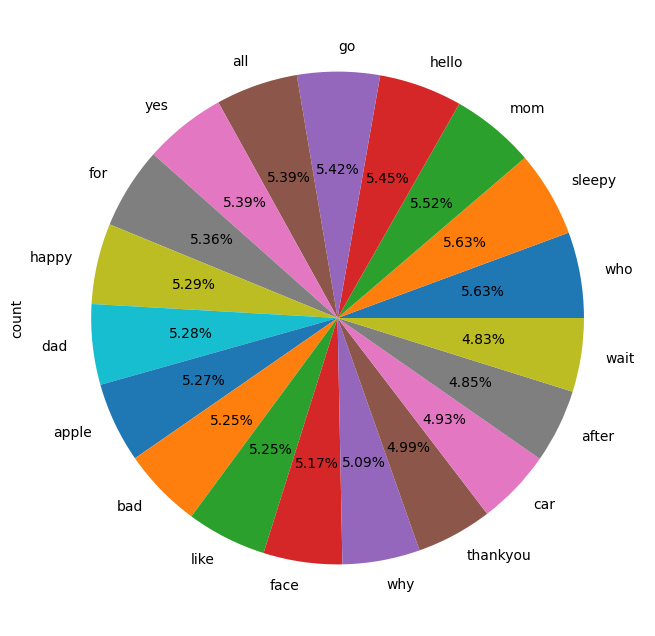

In [9]:
train_csv["sign"].value_counts().plot(kind="pie", autopct="%.2f%%", figsize=(8, 8))

We have a balanced samples for each sign

In [10]:
train_csv.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
path,7158,7158,train_landmark_files/28656/1000106739.parquet,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
participant_id,7158.0,NaN,NaN,NaN,33778.269349,16087.601713,2044.0,25571.0,32319.0,49445.0,62590.0
sequence_id,7158.0,NaN,NaN,NaN,2136477168.318664,1232501007.239071,1663109.0,1091177317.5,2128566050.5,3210493836.5,4293426127.0
sign,7158,19,who,403,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Loading parquet file 

In [11]:
ROWS_PER_FRAME = 543  # number of landmarks per frame


def load_relevant_data_subset(pq_path):
    data_columns = ["x", "y", "z"]
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

Creating additional data for more understanding

In [12]:
combined_meta = {}
for i, d in tqdm(train_csv.iterrows(), total=len(train_csv)):
    file_path = d["path"]
    example_landmark = pd.read_parquet(f"{file_path}")
    # Get the number of landmarks with x,y,z data per type
    meta = (
        example_landmark.dropna(subset=["x", "y", "z"])["type"].value_counts().to_dict()
    )
    meta["frames"] = example_landmark["frame"].nunique()
    xyz_meta = (
        example_landmark.agg(
            {
                "x": ["min", "max", "mean"],
                "y": ["min", "max", "mean"],
                "z": ["min", "max", "mean"],
            }
        )
        .unstack()
        .to_dict()
    )

    for key in xyz_meta.keys():
        new_key = key[0] + "_" + key[1]
        meta[new_key] = xyz_meta[key]
    combined_meta[file_path] = meta

  0%|          | 0/7158 [00:00<?, ?it/s]

In [13]:
meta_data = train_csv.merge(
    pd.DataFrame(combined_meta).T.reset_index().rename(columns={"index": "path"}),
    how="left",
)

In [ ]:
meta_data.to_parquet("Train_meta_data.parquet")
meta_data.to_csv("train_meta_data.csv")

In [4]:
meta_data = pd.read_parquet("Train_meta_data.parquet")

In [5]:
meta_data.head()

,path,participant_id,sequence_id,sign,face,pose,right_hand,frames,x_min,x_max,x_mean,y_min,y_max,y_mean,z_min,z_max,z_mean,left_hand
0,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait,5148.0,363.0,42.0,11.0,-0.017062,1.015931,0.554794,0.329273,2.222732,0.504912,-2.543970,1.627621,-0.040662,NaN
1,train_landmark_files/36257/1000536928.parquet,36257,1000536928,apple,6084.0,429.0,NaN,13.0,0.025914,0.989432,0.436484,0.396939,2.224238,0.555194,-3.482805,0.642032,-0.072594,210.0
2,train_landmark_files/32319/1001958254.parquet,32319,1001958254,go,11232.0,792.0,NaN,24.0,-0.199333,1.163158,0.400935,0.188694,2.305192,0.402923,-2.525885,1.561000,-0.058219,483.0
3,train_landmark_files/26734/100225301.parquet,26734,100225301,bad,22464.0,1584.0,525.0,48.0,-0.054401,1.347566,0.571264,0.225042,2.181761,0.384046,-2.436074,1.915501,-0.032378,NaN
4,train_landmark_files/53618/1004317038.parquet,53618,1004317038,face,2808.0,198.0,21.0,6.0,0.004053,1.045283,0.461140,0.172055,2.452384,0.390603,-3.579257,2.198036,-0.056071,NaN


## Checking the frequancy of each pose landmarks

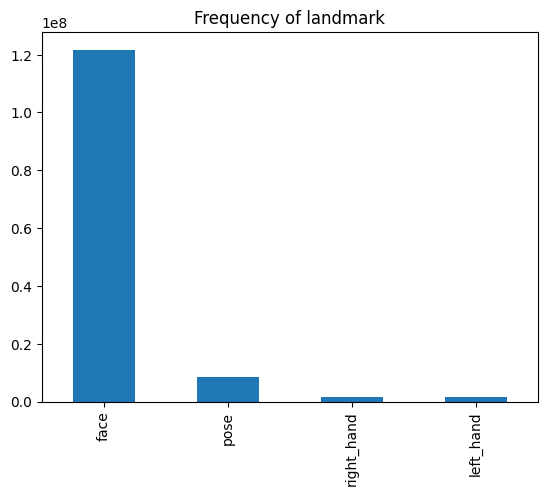

In [6]:
meta_data[["face", "pose", "right_hand", "left_hand"]].sum().plot(
    kind="bar", title="Frequency of landmark"
)
plt.show()

- Face has more datapoint since mediapipe provide 463 datapoint for face per frame

In [7]:
(meta_data.fillna(0)[["face", "pose", "left_hand", "right_hand"]] > 0).mean()

face          0.999022
pose          1.000000
left_hand     0.449707
right_hand    0.593741
dtype: float64

- All frame has pose as well as face datapoints
- Only 45% and 60% of the left and right hand datapoints respectively are null 

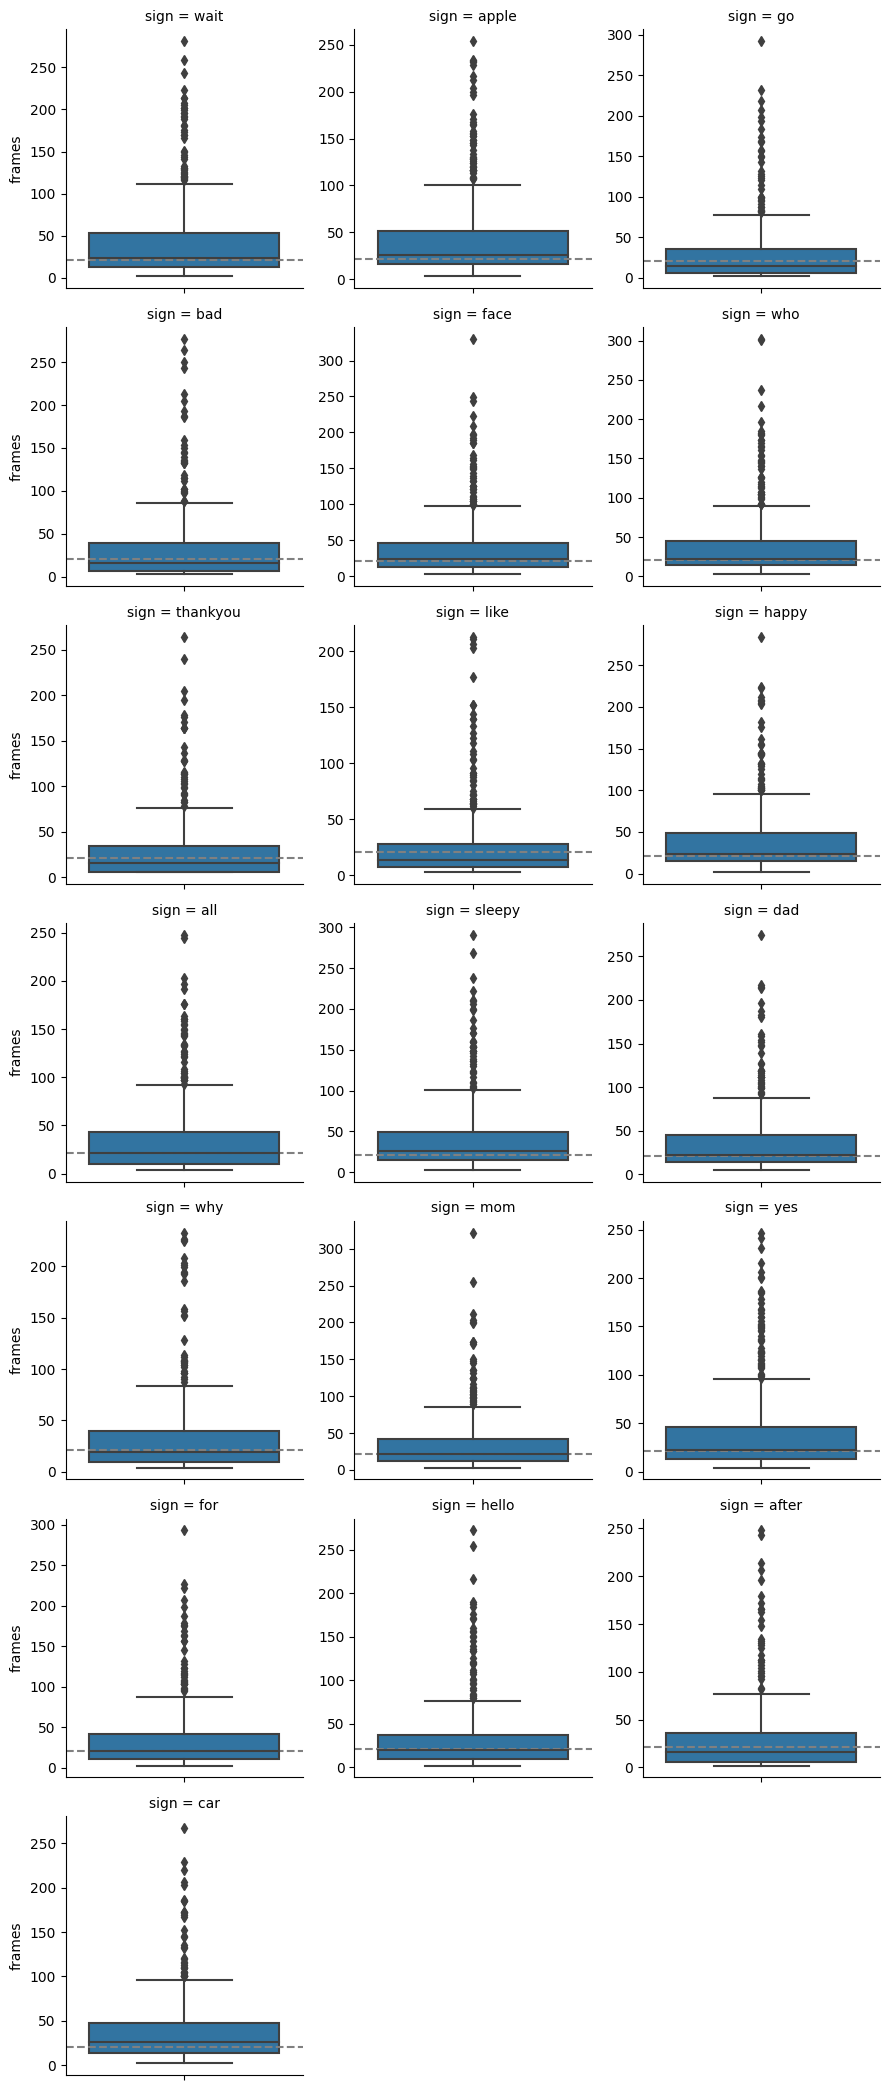

In [8]:
grid = sns.FacetGrid(meta_data, col="sign", col_wrap=3, sharex=False, sharey=False)
grid.map_dataframe(sns.boxplot, y="frames")
grid.refline(y=meta_data["frames"].median())
plt.show()

In [9]:
outliners_data = (
    meta_data.groupby("sign")
    .agg(
        {
            "frames": [
                "min",
                "max",
                "mean",
                "median",
                ("25 percentile", lambda x: np.percentile(x, 25)),
                ("50 percentile", lambda x: np.percentile(x, 50)),
                ("75 percentile", lambda x: np.percentile(x, 75)),
            ]
        }
    )
    .round()
)

In [10]:
outliners_data.columns = [
    "_".join(col).strip() for col in outliners_data.columns.values
]
outliners_data.reset_index(inplace=True)

In [11]:
outliners_data

,sign,frames_min,frames_max,frames_mean,frames_median,frames_25 percentile,frames_50 percentile,frames_75 percentile
0,after,2.0,248.0,30.0,16.0,6.0,16.0,36.0
1,all,4.0,248.0,37.0,21.0,10.0,21.0,43.0
2,apple,3.0,254.0,44.0,26.0,16.0,26.0,51.0
3,bad,3.0,277.0,32.0,16.0,7.0,16.0,39.0
4,car,2.0,267.0,40.0,26.0,14.0,26.0,48.0
5,dad,5.0,275.0,37.0,22.0,14.0,22.0,45.0
6,face,3.0,330.0,41.0,24.0,13.0,24.0,47.0
7,for,3.0,293.0,35.0,21.0,11.0,21.0,42.0
8,go,2.0,292.0,30.0,15.0,6.0,15.0,35.0
9,happy,2.0,284.0,40.0,23.0,16.0,23.0,49.0


In [12]:
outliners_data.describe().T

,count,mean,std,min,25%,50%,75%,max
frames_min,19.0,3.105263,1.100239,2.0,2.0,3.0,3.5,6.0
frames_max,19.0,273.315789,29.234783,213.0,251.0,275.0,291.5,330.0
frames_mean,19.0,36.578947,5.490555,26.0,32.5,37.0,40.5,46.0
frames_median,19.0,20.736842,3.827417,14.0,17.5,21.0,23.5,26.0
frames_25 percentile,19.0,11.263158,3.509386,6.0,8.5,12.0,14.0,16.0
frames_50 percentile,19.0,20.736842,3.827417,14.0,17.5,21.0,23.5,26.0
frames_75 percentile,19.0,42.736842,6.723442,28.0,38.0,43.0,47.5,54.0


- Here the sequance are of different length from length of 2 frames to 213 max frames with the mean frame being 26 frames per sign

# Number of datapoints for each landmarks output by the mediapipe :
- Face : 468
- pose : 33
- left hand : 21
- right hand : 21

In [13]:
# calculate the percentage of missing datapoint for each landmark for each sign.
def pec_hand_points(tuple):
    datapoint = tuple[0]
    frames = tuple[1]
    if np.isnan(datapoint):
        return 1
    else:
        return 1 - round(((datapoint / 21) / frames), 2)


def pec_pose_points(tuple):
    datapoint = tuple[0]
    frames = tuple[1]
    if np.isnan(datapoint):
        return 1
    else:
        return 1 - round(((datapoint / 33) / frames), 2)


def pec_face_points(tuple):
    datapoint = tuple[0]
    frames = tuple[1]
    if np.isnan(datapoint):
        return 1
    else:
        return 1 - round(((datapoint / 468) / frames), 2)

In [14]:
meta_data["pct_left_nan"] = meta_data[["left_hand", "frames"]].apply(
    pec_hand_points, axis=1
)
meta_data["pct_right_nan"] = meta_data[["right_hand", "frames"]].apply(
    pec_hand_points, axis=1
)
meta_data["pct_face_nan"] = meta_data[["face", "frames"]].apply(pec_face_points, axis=1)
meta_data["pct_pose_nan"] = meta_data[["pose", "frames"]].apply(pec_pose_points, axis=1)

In [29]:
fig = px.histogram(
    meta_data.fillna(0),
    ["pct_face_nan", "pct_pose_nan", "pct_left_nan", "pct_right_nan"],
    facet_col_wrap=2,
    facet_col="variable",
    log_y=True,
    height=750,
    nbins=20,
    labels={
        "variable": "",
        "value": "perecentage of points that are nan",
    },
)
fig.update_layout(showlegend=False)
fig.show()

- Pose landmarks has no nan values this means that all frames has pose datapoints.
- Face landmarks has some nan values but it is less common than then the hand landmarks.
- In hand landmarks there are some signs without the either left or right hand. 

Note: 

     - need to visulise the sign with no face
     
     - need to check if atlest one hand is present in a sign